In [1]:
from astropy.table import Table
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import os
from scipy.special import gammaincinv
from scipy.special import gammainc
from scipy.optimize import curve_fit

homedir = os.getenv("HOME")

In [2]:
# note: phot is an incomplete catalog, resulting in the available galaxies for comparison being about 
# 100 or so fewer than in my subsample.

re_comp = Table.read(homedir+'/github/research/12_micron_re_comparison.fits')

#for AGN cuts
wise = Table.read(homedir+'/Desktop/v1-20210308/vf_north_v1_unwise.fits')

#for BPT AGN cuts
bpt = Table.read(homedir+'/Desktop/v1-20210308/vf_north_v1_nsa_v0.fits')

#677 galaxy subsample
vf_sample = Table.read(homedir+'/github/research/vf_sample.fits')

#full phot catalog
phot = Table.read(homedir+'/Downloads/virgofilaments-v2-legacyphot.fits',hdu=2)

#full hyperleda catalog
hyp = Table.read(homedir+'/Desktop/v1-20210308/vf_north_v1_hyperleda.fits')

#full vf table
vf = Table.read(homedir+'/Desktop/v1-20210308/vf_north_v1_main.fits')

#GALFIT parameters (psf)
t2 = Table.read(homedir+'/psf_params.txt',format='ascii')

FileNotFoundError: [Errno 2] No such file or directory: '/Users/k215c316/github/research/12_micron_re_comparison.fits'

In [ ]:
#trimming the above catalogs to match the length of re_comp

vf1 = []
for i in range(0,len(re_comp)):
    vfid = re_comp['objname'][i]
    vfid = vfid.strip()    #removes strange white space to the right of objname entries
    vf1.append(vfid)
vf2 = []
for i in range(0,len(hyp)):
    vfid = str(hyp['objname'][i])
    vf2.append(vfid)
    
flag = []
for i in vf2:
    if i in vf1:
        flag.append(True)
    else:
        flag.append(False)

In [ ]:
hyp = hyp[flag]
bpt = bpt[flag]
wise = wise[flag]
vf = vf[flag]

In [ ]:
#wise_agn flag
wise_agn = np.where((wise['w1_mag'] - wise['w2_mag']>0.75) & (wise['w2_mag']-wise['w3_mag']<4.0))[0]

In [ ]:
#bpt_agn flag
bpt_agn = np.where((np.log10(bpt['O3FLUX']/bpt['HBFLUX']) > (.61/(np.log10(bpt['N2FLUX']/bpt['HAFLUX']-.05))+1.3)) | (np.log10(bpt['N2FLUX']/bpt['HAFLUX']) > 0.))[0]

In [ ]:
#confirming that column names for galaxy names (from the two different catalogs) are consistent
#(I matched in TOPCAT according to RA & DEC with a somewhat large separation, so consistency checks are helpful)

for i in range(0,len(re_comp)):
    if re_comp['GALAXY'][i][0:8] != re_comp['objname'][i][0:8]:
        print('n')

In [ ]:
#calculating 12-micron Re from photometry parameters

#note: parameters are dimensionless, so multiplying by 10 arcsec yields an Re in arcsec

r0 = 10 #arcsec
alpha_1 = re_comp['COG_ALPHA1_W2']
alpha_2 = re_comp['COG_ALPHA2_W2']
m0 = re_comp['COG_M0_W2']

comp_one = np.log10(0.5)/(0.4*m0)
comp_two = np.exp(-comp_one) - 1
comp_three = (1/alpha_1) * comp_two
comp_four = comp_three**(-1/alpha_2)

r50_phot_w3 = r0 * comp_four

In [ ]:
#note: GALFIT 12-micron Re already multiplied by 2.75 arcsec/px conversion factor

r50_galfit_w3 = re_comp['re_12micron']

In [ ]:
plt.figure(figsize=(10,6))
plt.scatter(r50_galfit_w3,r50_phot_w3,s=20)

plt.xlabel('r50_GALFIT (arcsec)',fontsize=15)
plt.ylabel('r50_phot (arcsec)',fontsize=15)
plt.scatter(r50_galfit_w3[wise_agn],r50_phot_w3[wise_agn],s=100,color='red',facecolors='none',label='WISE AGN')
plt.scatter(r50_galfit_w3[bpt_agn],r50_phot_w3[bpt_agn],s=100,color='green',facecolors='none',label='BPT AGN')
plt.plot([1.,1000.],[1.,1000.],label='1-to-1 Line',color='green',alpha=0.4)
plt.xscale('log')
plt.yscale('log')

plt.xlim(5,200)
plt.ylim(5,3000)
plt.legend()
plt.show()

In [ ]:
#there are three regimes to concentrate on here:
#  1. region underneath the curve
#  2. bottom left cluster of galaxies above the curve (i.e., those with small r50 radii, perhaps < W3 FWHM)
#  3. upper diffuse cloud
#of these, visually inspect (3).

In [ ]:
hyp['objname'][r50_phot_w3>100]

-------

In [3]:
#visual inspection did not yield favorable results - GALFIT seems to generate central flux overestimations 
#and outskirts underestimations for a number of galaxies, John's photometry may contain a masking routine
#that is a bit aggressive, and many of the postage stamps used for the latter feature background 
#oversubtractions and whatnot. thus is the status of the project. pending extensive discussion with my
#overlords, I may as well transition to testing for whether there are systematics driving the discrepancies
#between the GALFIT and J_photometry techniques. 

#this aim I have decomposed into the following steps:
#  1. calculate integral of I(r), which I accomplished in a previous notebook from Dec 2020
#  2. generate an array of this integrated I(r) for a range of r values, with some given r50 value and nser
#  3. convert I(r) flux to magnitude
#  4. apply curve_fit to J_photometry (John's COG empirical model) to extract parameters fit to Sersic COG
#  5. plot results, find the J_photometry r50 and compare to the given r50

#I then compile a set of plots with this fixed Sersic r50 value for a variety of nser.

Note first that John's curve of growth (COG) empirical model is given as:
#### $m(r) = m_{tot} + m_0\ln{(1+\alpha_1(\frac{r}{r_0})^{-\alpha_2})}$
The 2D surface brightness distribution of a Sersic profile is 
#### $I(r) = I_e \exp{[-b_n((\frac{r}{r_e})^{1/n}-1)]}$,
where \
$I_e = I(r_e)$ \
$b_n$ is defined such that $r_e$ contains 1/2 the total flux of the profile \
b_n = gammaincinv(2.*n, 0.5) \
Integrated, the function I(r) is
#### $I(r) = \frac{2\pi n r_e^2}{b_n^{2n}}I_e e^{b_n}\gamma(2n, b_n (\frac{r}{r_e})^{1/n}$)


In [4]:
#I received permission to set I_e = 1, since this term is simply a brightness normalization

I_e = 1
#will choose a variety of n values
n = .5
#assume re is in arcseconds
re_arbitrary = 50
b_n = gammaincinv(2*n, 0.5)
r = np.arange(1,7*re_arbitrary,0.01)
ratio = r/re_arbitrary

constant = 2*np.pi*n*(re_arbitrary**2)/b_n**(2*n)
gamma_term = gammainc(2*n,b_n*ratio**(1/n))
I = constant*I_e*np.exp(b_n)*gamma_term
#select arbitrary zero point (22.5), only shifts the curve and this higher value prevents potential errors due to
#negative mag values in the logarithm)
mag = 25-2.5*np.log10(I)

In [5]:
#let's extract J_photometry parameters from the data!
#assume a = mtot, b = m_0, c = alpha1, d = alpha2
r0 = 10.

#note that this function differs slightly from the m(r) empirical model --> the fit only occurs if the 
#exponent acting on (r/r0) is d rather than -d.
def func(r, a, b, c, d):
    r0 = 10.
    return a + b*np.log(1 + c*((r/r0)**(-d)))

popt = curve_fit(func,r,mag,maxfev=8000)[0]
a = popt[0]
b = popt[1]
c = popt[2]
d = popt[3]
print(popt)

r50_curvefit = r0*((1/c)*(np.exp(-np.log10(0.5)/(0.4*b))-1))**(-1/d)

[1.41008741e+01 5.71377985e-01 9.93942946e+02 3.69297003e+00]


/var/folders/gx/q5wqxlgs0rgfm6f87vgxlgyw4s52w0/T/ipykernel_62387/59945508.py:9: RuntimeWarning: invalid value encountered in log
  return a + b*np.log(1 + c*((r/r0)**(-d)))


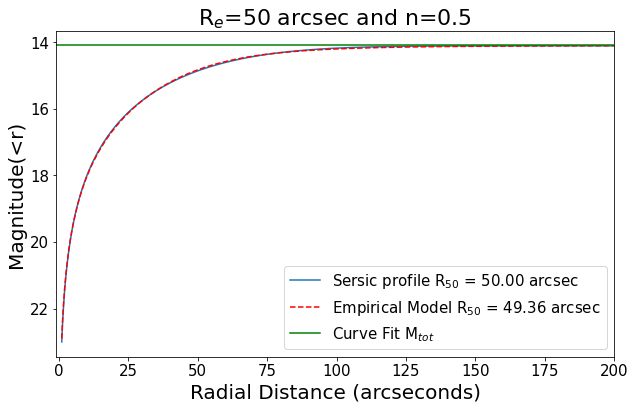

In [6]:
plt.figure(figsize=(10,6))
plt.plot(r,mag,label=r'Sersic profile R$_{50}$ = %.2f arcsec'%re_arbitrary)
plt.plot(r, func(r, *popt), 'r--',label=r'Empirical Model R$_{50}$ = %.2f arcsec'%r50_curvefit)
plt.xlabel('Radial Distance (arcseconds)',fontsize=20)
plt.ylabel('Magnitude(<r)',fontsize=20)

plt.axhline(y=a,color='green',label=r'Curve Fit M$_{tot}$')
plt.gca().invert_yaxis()

plt.title(r'R$_e$='+str(re_arbitrary)+' arcsec and n='+str(n),fontsize=22)
plt.legend(fontsize=15,loc='lower right')

plt.xlim(-1,200)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.savefig(homedir+'/Desktop/cog.png', bbox_inches='tight', pad_inches=0.2, dpi=100)

In [7]:
#gewd. and both converge around the mtot (total magnitude) line. no systematics..?

In [8]:
#nächste, I include in this notebook a plot of the SGA r-band size vs. the legacyphot-v2 r-band size

In [93]:
#table for SGA r-band parameters
sga_params = Table.read(homedir+'/sga_params')
#relevant columns: 'R_COG_PARAMS_MTOT','R_COG_PARAMS_M0','R_COG_PARAMS_ALPHA1','R_COG_PARAMS_ALPHA2','objname'
#note: hyp and sga_params are not the same length initially.

In [102]:
vf3 = []
for i in range(0,len(sga_params)):
    vfid = sga_params['GALAXY'][i]
    vfid = vfid.strip()    #removes any strange white space to the right of objname entries
    vf3.append(vfid)
vf4 = []
for i in range(0,len(hyp)):
    vfid = str(hyp['objname'][i])
    vf4.append(vfid)
    
flag_trimsga = []
for i in vf3:
    if i in vf4:
        flag_trimsga.append(True)
    else:
        flag_trimsga.append(False)

sga_params = sga_params[flag_trimsga]

flag_trimhyp = []
for i in vf4:
    if i in vf3:
        flag_trimhyp.append(True)
    else:
        flag_trimhyp.append(False)

hyp_trim = hyp[flag_trimhyp]
re_comp_trim = re_comp[flag_trimhyp]
vf_trim = vf[flag_trimhyp]

In [95]:
#checking length
len(sga_params)/len(hyp_trim)

1.0

In [96]:
#to ensure column names are in proper order, I isolate the objname column here and ensure no extraneous ' '
sga_objname = []
for i in sga_params['objname']:
    vfid = i.strip() 
    sga_objname.append(vfid)
hyp_objname = []
for i in hyp_trim['objname']:
    vfid = i.strip()
    hyp_objname.append(vfid)

In [97]:
#SGA r50 (r-band)
r0 = 10 #arcsec
alpha_1 = sga_params['R_COG_PARAMS_ALPHA1']
alpha_2 = sga_params['R_COG_PARAMS_ALPHA2']
m0 = sga_params['R_COG_PARAMS_M0']

comp_one = np.log10(0.5)/(0.4*m0)
comp_two = np.exp(-comp_one) - 1
comp_three = (1/alpha_1) * comp_two
comp_four = comp_three**(-1/alpha_2)

r50_sga_tentative = r0 * comp_four

In [98]:
#phot r50 (r-band)
r0 = 10 #arcsec
alpha_1 = re_comp_trim['COG_ALPHA1_R']
alpha_2 = re_comp_trim['COG_ALPHA2_R']
m0 = re_comp_trim['COG_M0_R']

comp_one = np.log10(0.5)/(0.4*m0)
comp_two = np.exp(-comp_one) - 1
comp_three = (1/alpha_1) * comp_two
comp_four = comp_three**(-1/alpha_2)

r50_phot_r = r0 * comp_four

In [163]:
#rearrange r50_sga_tentative to match order of r50_phot_r

sga_mtot_r_tentative = sga_params['R_COG_PARAMS_MTOT']

r50_sga_r = []
mtot_sga_r = []
sga_objname_rearranged = []
sga_objname = np.asarray(sga_objname)
hyp_objname = np.asarray(hyp_objname)
for i in range(0,len(hyp_trim)):
    galname = hyp_objname[i]
    #find index at which sga_params fits the hyp galname 
    index = np.where(sga_objname == galname)[0][0]
    #use that index to extract r50_tentative element and place in r50
    r50_sga_r.append(r50_sga_tentative[index])
    mtot_sga_r.append(sga_mtot_r_tentative[index])
    #do likewise to sga_params galname -- if vfid is in the hyp_objname order, then all is well.
    #(I have deleted the cell which confirms this correct order.)
    sga_objname_rearranged.append(sga_objname[index])

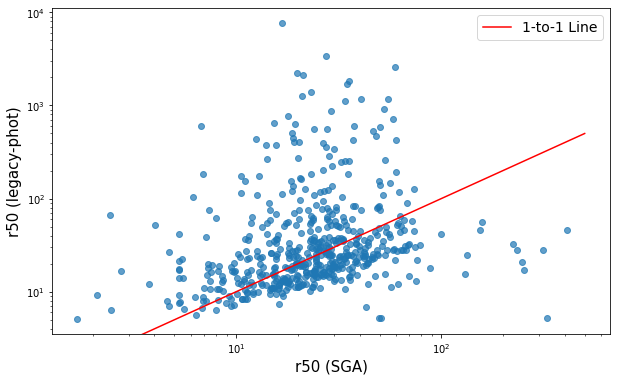

In [100]:
#I now have r50_sga_r, and from above I also have r50_phot_r. Comparison time.
plt.figure(figsize=(10,6))
plt.scatter(r50_sga_r,r50_phot_r,alpha=0.7)
plt.plot([0,500],[0,500],color='r',label='1-to-1 Line')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('r50 (SGA)',fontsize=15)
plt.ylabel('r50 (legacy-phot)',fontsize=15)
plt.legend(fontsize=14)

In [108]:
#and now, a plot of re_phot/re_galfit vs. Mtot_COG - Mtot_galfit (all W3 band) to check if largest radii offsets a
#also have large magnitude offsets

#first ensure t2 and vf_trim are the same length
param_galname = t2['galname']
vf_galname = vf_trim['prefix']
t2_flag = []
for i in param_galname:
    if i in vf_galname:
        t2_flag.append(True)
    else:
        t2_flag.append(False)
t2_trim = t2[t2_flag]

#isolate t2 magnitude column
mtot_galfit = t2_trim['mag']

(-1.0, 1.0)

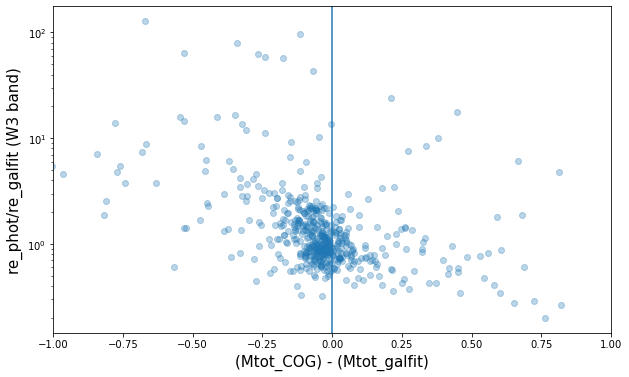

In [209]:
#dmag = re_comp['COG_MTOT_R'] - (22.5 - 2.5*np.log10(re_comp['FLUX_AP04_R']))

#subtracted 5.174, which is the AB/Vega mag offset
#https://wise2.ipac.caltech.edu/docs/release/allsky/expsup/sec4_4h.html
dmag = (re_comp_trim['COG_MTOT_W3'] - mtot_galfit) - 5.174
re_ratio = r50_phot_w3[flag_trimhyp]/r50_galfit_w3[flag_trimhyp]

plt.figure(figsize=(10,6))
plt.scatter(dmag,re_ratio,alpha=0.3)
plt.ylabel('re_phot/re_galfit (W3 band)',fontsize=15)
plt.xlabel('(Mtot_COG) - (Mtot_galfit)',fontsize=15)
plt.axvline(0)
plt.yscale('log')
plt.xlim(-1,1)

In [168]:
tab = Table([vf_trim['objname'],vf_trim['prefix'],vf_trim['RA'],vf_trim['DEC'],r50_phot_r,r50_sga_r,
             r50_phot_w3[flag_trimhyp],r50_galfit_w3[flag_trimhyp],mtot_galfit,re_comp_trim['COG_MTOT_W3'],
             re_comp_trim['COG_MTOT_R'],mtot_sga_r,],
            names=['objname','prefix','RA','DEC','r50_phot_r','r50_sga_r','r50_phot_w3','r50_galfit_w3',
                   'mtot_galfit_w3','COG_MTOT_W3','COG_MTOT_R','MTOT_SGA_R'])
tab

objname,prefix,RA,DEC,r50_phot_r,r50_sga_r,r50_phot_w3,r50_galfit_w3,mtot_galfit_w3,COG_MTOT_W3,COG_MTOT_R,MTOT_SGA_R
,,,,,,,,,mag,mag,
bytes28,bytes36,float64,float64,float32,float32,float32,float64,float64,float32,float32,float32
NGC4133,VFID0001-NGC4133,182.208,74.9042778,27.422113,18.736118,19.990719,12.154725000000001,5.6642,10.759662,12.037512,12.077573
NGC2977,VFID0002-NGC2977,145.944663,74.8595778,19.105068,21.219566,17.76339,17.952275,5.7767,10.923155,12.392807,12.4811735
NGC3752,VFID0005-NGC3752,173.1341835,74.6275401,20.643026,38.052376,18.683334,19.940525,6.7812,11.972227,12.827588,12.5642395
NGC6643,VFID0008-NGC6643,274.943166,74.5683889,43.835594,47.299225,32.313747,35.138125,3.8584,9.065144,11.154333,10.965347
NGC3155,VFID0011-NGC3155,154.4161905,74.3473859,18.764126,18.8092,18.564894,11.908325000000001,7.3553,12.431754,13.316351,13.210415
UGC04883,VFID0013-UGC04883,139.6340505,74.3191954,10.737344,8.093349,12.349472,5.8421,7.1449,12.2832575,12.455461,12.468728
NGC3183,VFID0019-NGC3183,155.4540195,74.1769917,38.97678,28.276186,19.54542,27.354525000000002,5.2606,10.399768,11.581383,11.818163
PGC026731,VFID0026-CGCG332-048,141.41841599999998,73.9001194,8.454124,11.294432,8.262447,5.76565,7.8855,13.071012,13.881661,13.9861145


(7.0, 16.85)

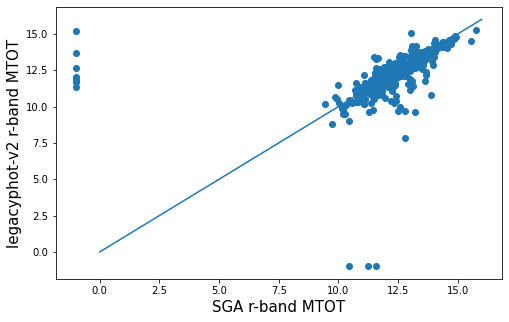

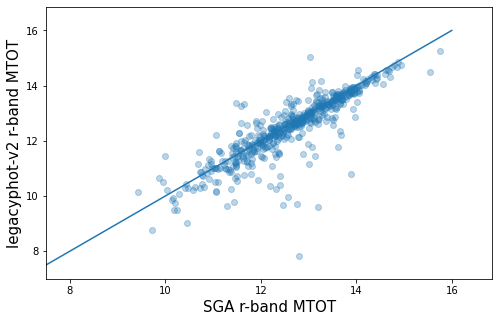

In [210]:
#plot SGA r-band total COG magnitude vs. legacyphot-v2 r-band total COG magnitude to determine if offsets in
#r50 correspond to offsets in magnitude.

plt.figure(figsize=(8,5))
plt.scatter(tab['MTOT_SGA_R'],tab['COG_MTOT_R'])
plt.plot([0,16],[0,16])
plt.xlabel('SGA r-band MTOT',fontsize=15)
plt.ylabel('legacyphot-v2 r-band MTOT',fontsize=15)

plt.figure(figsize=(8,5))
plt.scatter(tab['MTOT_SGA_R'],tab['COG_MTOT_R'],alpha=0.3)
plt.plot([0,16],[0,16])
plt.xlabel('SGA r-band MTOT',fontsize=15)
plt.ylabel('legacyphot-v2 r-band MTOT',fontsize=15)
plt.xlim(7.5)
plt.ylim(7)

-----

In [249]:
#re_comp --> PA_MOMENT, BA_MOMENT (legacyphot)
#        --> pa, ba (Hyperleda)

In [233]:
phot_pa = re_comp['PA_MOMENT']
phot_ba = re_comp['BA_MOMENT']

In [237]:
vf.add_columns([phot_pa,phot_ba],names=['PA_MOMENT','BA_MOMENT'])

In [243]:
#will run this test on galaxies with well constrained PA and inclination, meaning that Hyperleda and
#JM's legacyphot agree to within a certain percent
paba_flag = (phot_pa/re_comp['pa']>0.6) & (phot_pa/re_comp['pa']<1.4)

In [248]:
vf.write('vf_paba_fixed.fits',overwrite=True)